# CapsNet

Based on the paper by G Hinton [arxiv:1710.09829]

A full-hearted approach to translate Hinton's paper into code and learn along the way.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Let's get started by importing the data (if you do not have it will download it for you), aka MNIST

In [2]:
data_dir = 'MNIST_data/'
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(data_dir, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [24]:
img = mnist.train.next_batch(1)

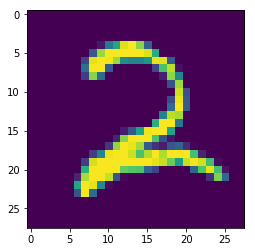

In [25]:
#Sanity Check
plt.imshow(np.reshape(img[0], (28, 28)))

A big shout out to Aurélien Géron for putting out a [video](https://www.youtube.com/watch?v=pPN8d0E3900) explaining the complete paper in all its glory. Without the video it would have been exponentially hard for me to get this right in the first shot. You can reach him [Twitter](https://twitter.com/aureliengeron).

If you have any suggestion or query for me, ping me on @khandelia1000 on twitter.

## Let's 'squash'

Okay, we now have the data inplace, let's start building our Capsule Network.

The first thing we do is define the operation squashing with the help of a function, we follow the paper word by word except for the place were we add this extra epsilon for the purpose of stablisation

In [3]:
#First and foremost we need to build module for the 'squashing' operation

def squashed(s_j, epsilon = 10**-6, axis=-1, name=None):
    '''
    Squashes the input as defined in arxiv:1710.09829
    args:
            s_j: A vector that will be squashed
            epsilon: a very small scaler value to ensure that the division is stable
    returns
            V_j: A vector that exits in the same vector space (i.e. have same dimensions) as s_j
    '''
    with tf.name_scope(name, default_name = 'squashed'):
        epsilon = 10**-6 # a very small value to ensure that the division is stable
        squared_s_j = tf.reduce_sum(tf.square(s_j), axis=axis, keepdims=True)
        stable_squared_s_j = squared_s_j + epsilon
        denominator = 1 + stable_squared_s_j
        multiplier = stable_squared_s_j/denominator
        normalised_s_j = s_j/tf.sqrt(stable_squared_s_j)
        return multiplier * normalised_s_j

Now that we have definded the squashing operation and let's write down the routing algorithm

In [4]:
def routing_loop_body(u_hat, r, b):
    '''
        Routing body as described in the paper
    '''
    coefficients_c = tf.nn.softmax(b)
    s_j = tf.einsum('ijkl,jk->ikl', u_hat, coefficients_c)
    v_j = squashed(s_j)
    b = b + tf.einsum('ijkl,ikl->jk', u_hat, v_j)
    r -= 1
    return u_hat, r, b

def routing_loop_condition(u_hat, r, b):
    return r > 0

In [5]:
# Let's calculate our loss
def loss(Y, Y_hat):
    m_plus, m_minus, down_weighting_factor = 0.9, 0.1, 0.5
    loss_part_two = tf.divide(tf.reduce_sum(down_weighting_factor * tf.multiply((1.0 - Y), tf.square(tf.maximum(0.0, Y_hat - m_minus))), axis=0), tf.cast(tf.shape(Y)[0], dtype=tf.float32))
    loss_part_one = tf.divide(tf.reduce_sum(tf.multiply(Y, tf.square(tf.maximum(0.0, m_plus - Y_hat))), axis=0), tf.cast(tf.shape(Y)[0], dtype=tf.float32))
    loss = tf.reduce_sum(loss_part_one + loss_part_two)
    return loss

In [ ]:
# Data to test the code
# X = tf.constant([np.reshape(img, (28, 28, 1))]*2)

In [6]:
# Dataset input through dict_feed
X = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1))
Y = tf.placeholder(dtype=tf.float32, shape=(None, 10))

# Algo for capsnet
with tf.variable_scope('network', reuse=tf.AUTO_REUSE):
    # Preprocessing for the capsule network
    conv2d_1 = tf.layers.conv2d(X, filters = 256, kernel_size=(9,9), strides=(1,1))
    conv2d_2 = tf.layers.conv2d(conv2d_1, filters = 256, kernel_size=(9, 9), strides=(2,2))
    
    # Transform the conv2d to capsnet using resize
    caps_one_input = tf.reshape(conv2d_2, shape=(-1, 32*6*6, 8))
    caps_one_output = squashed(caps_one_input)
    
    # Declare the weight matrix for the tranformation of a vector from lower dimension to higher dimension
    weight_matrix = tf.get_variable('weight_matrix', shape=(32*6*6, 10, 8, 16), initializer=tf.contrib.layers.xavier_initializer())

    #Let's do the matrix multiplication, to get the u_hat_j|i, we will use our dear einstein for that
    u_hat = tf.einsum('ijkl,aik->aijl', weight_matrix, caps_one_output) #abdc,iabcf->iabdf
    
    # Declare the logits and start the while loop with r=3
    log_prior_probabilities = tf.zeros(shape=(32*6*6, 10))
    r = 3
    _, r_, log_prior_probabilities_processed = tf.while_loop(routing_loop_condition, routing_loop_body, loop_vars=[u_hat, r, log_prior_probabilities])
    
    #Compute the output of the last layer using the processed log_prior_probabilities
    coefficients_c = tf.nn.softmax(log_prior_probabilities_processed)
    caps_two_input = tf.einsum('ijkl,jk->ikl', u_hat, coefficients_c)
    caps_two_output = squashed(caps_two_input)
    
    #Magnitude of the 16 dimentional vector will give us the probability
    Y_hat = tf.sqrt(tf.einsum('ijk,ijk->ij', caps_two_output, caps_two_output))

loss_ = loss(Y, Y_hat)
optimizer = tf.train.AdamOptimizer().minimize(loss=loss_)

In [22]:
# Let us train the net
epochs, mini_batch_size = 1000, 32
saver = tf.train.Saver()
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for epoch in range(epochs):
        data = mnist.train.next_batch(mini_batch_size)
        xs, ys = np.reshape(data[0],(-1, 28, 28, 1)), data[1]
        _, loss_one = sess.run([optimizer, loss_], feed_dict={X:xs, Y:ys})
        test_data = mnist.test.next_batch(mini_batch_size)
        xs_test, ys_test = np.reshape(test_data[0],(-1, 28, 28, 1)), test_data[1]
        prob = sess.run(Y_hat, feed_dict={X:np.reshape(xs_test, (-1, 28, 28, 1))})
        prediction = np.argmax(prob, 1)
        reality = np.argmax(ys_test, 1)
        equality = np.equal(prediction, reality)
        accuracy = np.mean(equality.astype(float))
        print('Epoch #', epoch)
        print('Loss: ', loss_one)
        print('Accuracy: ', accuracy)
        if epoch%10 == 0:
            path = saver.save(sess, "model_epoch.ckpt")
            print("Saved at ", str(path))

Epoch # 0
Loss:  0.80999875
Accuracy:  0.3125
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 1
Loss:  0.80997145
Accuracy:  0.21875
Epoch # 2
Loss:  0.7803559
Accuracy:  0.125
Epoch # 3
Loss:  0.909694
Accuracy:  0.03125
Epoch # 4
Loss:  0.71341085
Accuracy:  0.09375
Epoch # 5
Loss:  0.79951185
Accuracy:  0.21875
Epoch # 6
Loss:  0.7257294
Accuracy:  0.1875
Epoch # 7
Loss:  0.79811496
Accuracy:  0.125
Epoch # 8
Loss:  0.71096295
Accuracy:  0.0
Epoch # 9
Loss:  0.65566
Accuracy:  0.15625
Epoch # 10
Loss:  1.36323
Accuracy:  0.0625
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 11
Loss:  0.8920604
Accuracy:  0.125
Epoch # 12
Loss:  0.60788924
Accuracy:  0.03125
Epoch # 13
Loss:  1.4795579
Accuracy:  0.0625
Epoch # 14
Loss:  1.2741663
Accuracy:  0.125
Epoch # 15
Loss:  0.9464397
Accuracy:  0.15625
Epoch # 16
Loss:  0.9317218
Accuracy:  0.125
Epoch # 17
Loss:  0.95590657
Accuracy:  0.125
Epoch # 18
Loss:  0.8259442
Accur

Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 151
Loss:  0.15031347
Accuracy:  0.9375
Epoch # 152
Loss:  0.14560351
Accuracy:  0.9375
Epoch # 153
Loss:  0.15024297
Accuracy:  0.84375
Epoch # 154
Loss:  0.113755815
Accuracy:  0.84375
Epoch # 155
Loss:  0.1438212
Accuracy:  0.9375
Epoch # 156
Loss:  0.11206493
Accuracy:  0.9375
Epoch # 157
Loss:  0.15503998
Accuracy:  0.84375
Epoch # 158
Loss:  0.15217979
Accuracy:  0.84375
Epoch # 159
Loss:  0.13735226
Accuracy:  0.96875
Epoch # 160
Loss:  0.14824219
Accuracy:  0.78125
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 161
Loss:  0.1513704
Accuracy:  0.875
Epoch # 162
Loss:  0.14907447
Accuracy:  0.96875
Epoch # 163
Loss:  0.1040467
Accuracy:  0.9375
Epoch # 164
Loss:  0.13651274
Accuracy:  0.90625
Epoch # 165
Loss:  0.15485486
Accuracy:  0.875
Epoch # 166
Loss:  0.12619439
Accuracy:  0.9375
Epoch # 167
Loss:  0.15206538
Accuracy:  0.875
Epoch # 168
Loss:  0.16928491
Acc

Epoch # 298
Loss:  0.08635423
Accuracy:  0.96875
Epoch # 299
Loss:  0.12188113
Accuracy:  0.96875


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ValueError: embedded null byte


Epoch # 300
Loss:  0.07943913
Accuracy:  0.8125
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 301
Loss:  0.10535659
Accuracy:  0.90625
Epoch # 302
Loss:  0.1253922
Accuracy:  0.96875
Epoch # 303
Loss:  0.09686032
Accuracy:  0.96875
Epoch # 304
Loss:  0.061094053
Accuracy:  0.90625
Epoch # 305
Loss:  0.09797138
Accuracy:  0.8125
Epoch # 306
Loss:  0.08520796
Accuracy:  0.90625
Epoch # 307
Loss:  0.08227283
Accuracy:  0.96875
Epoch # 308
Loss:  0.08979548
Accuracy:  1.0
Epoch # 309
Loss:  0.06807063
Accuracy:  0.84375
Epoch # 310
Loss:  0.11031755
Accuracy:  0.96875
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 311
Loss:  0.12260935
Accuracy:  0.9375
Epoch # 312
Loss:  0.09095036
Accuracy:  0.875
Epoch # 313
Loss:  0.084005445
Accuracy:  0.8125
Epoch # 314
Loss:  0.11025769
Accuracy:  0.90625
Epoch # 315
Loss:  0.11670171
Accuracy:  0.96875
Epoch # 316
Loss:  0.07624021
Accuracy:  0.96875
Epoch # 317
Loss:  0.1562754

Epoch # 447
Loss:  0.10692317
Accuracy:  0.9375
Epoch # 448
Loss:  0.095046975
Accuracy:  0.875
Epoch # 449
Loss:  0.094823785
Accuracy:  0.90625
Epoch # 450
Loss:  0.07778233
Accuracy:  0.90625
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 451
Loss:  0.08220973
Accuracy:  0.96875
Epoch # 452
Loss:  0.07703263
Accuracy:  1.0
Epoch # 453
Loss:  0.0808903
Accuracy:  0.9375
Epoch # 454
Loss:  0.09393105
Accuracy:  0.96875
Epoch # 455
Loss:  0.09418796
Accuracy:  0.96875
Epoch # 456
Loss:  0.09738964
Accuracy:  0.96875
Epoch # 457
Loss:  0.09446925
Accuracy:  0.90625
Epoch # 458
Loss:  0.14593115
Accuracy:  0.90625
Epoch # 459
Loss:  0.13085753
Accuracy:  0.90625
Epoch # 460
Loss:  0.11985098
Accuracy:  0.90625
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 461
Loss:  0.1369789
Accuracy:  0.96875
Epoch # 462
Loss:  0.0856171
Accuracy:  0.9375
Epoch # 463
Loss:  0.13345811
Accuracy:  0.9375
Epoch # 464
Loss:  0.11980486


Epoch # 594
Loss:  0.06980567
Accuracy:  0.90625
Epoch # 595
Loss:  0.07712771
Accuracy:  1.0
Epoch # 596
Loss:  0.07001129
Accuracy:  0.96875
Epoch # 597
Loss:  0.05906316
Accuracy:  0.875
Epoch # 598
Loss:  0.106965035
Accuracy:  0.9375
Epoch # 599
Loss:  0.07013969
Accuracy:  0.96875
Epoch # 600
Loss:  0.10075312
Accuracy:  0.9375
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 601
Loss:  0.07070124
Accuracy:  0.9375
Epoch # 602
Loss:  0.08212642
Accuracy:  0.96875
Epoch # 603
Loss:  0.064615145
Accuracy:  0.90625
Epoch # 604
Loss:  0.10112357
Accuracy:  0.96875
Epoch # 605
Loss:  0.07958386
Accuracy:  0.90625
Epoch # 606
Loss:  0.0551922
Accuracy:  0.96875
Epoch # 607
Loss:  0.05498808
Accuracy:  0.9375
Epoch # 608
Loss:  0.06317783
Accuracy:  0.875
Epoch # 609
Loss:  0.08894708
Accuracy:  0.9375
Epoch # 610
Loss:  0.08691439
Accuracy:  0.90625
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 611
Loss:  0.12378944
A

Epoch # 742
Loss:  0.067867436
Accuracy:  0.96875
Epoch # 743
Loss:  0.06382409
Accuracy:  0.875
Epoch # 744
Loss:  0.06873079
Accuracy:  0.96875
Epoch # 745
Loss:  0.08555501
Accuracy:  0.96875
Epoch # 746
Loss:  0.058998995
Accuracy:  0.90625
Epoch # 747
Loss:  0.057634182
Accuracy:  0.90625
Epoch # 748
Loss:  0.074080914
Accuracy:  0.90625
Epoch # 749
Loss:  0.067299545
Accuracy:  1.0
Epoch # 750
Loss:  0.0829069
Accuracy:  0.9375
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 751
Loss:  0.05588584
Accuracy:  0.90625
Epoch # 752
Loss:  0.07129409
Accuracy:  1.0
Epoch # 753
Loss:  0.050742704
Accuracy:  0.9375
Epoch # 754
Loss:  0.07337687
Accuracy:  0.96875
Epoch # 755
Loss:  0.08958716
Accuracy:  0.96875
Epoch # 756
Loss:  0.08021895
Accuracy:  0.9375
Epoch # 757
Loss:  0.09213191
Accuracy:  0.9375
Epoch # 758
Loss:  0.05090077
Accuracy:  0.96875
Epoch # 759
Loss:  0.07180005
Accuracy:  0.9375
Epoch # 760
Loss:  0.04169243
Accuracy:  0.96875
Saved

Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 891
Loss:  0.06566936
Accuracy:  0.9375
Epoch # 892
Loss:  0.08369008
Accuracy:  1.0
Epoch # 893
Loss:  0.046130665
Accuracy:  0.9375
Epoch # 894
Loss:  0.052773334
Accuracy:  0.90625
Epoch # 895
Loss:  0.049656484
Accuracy:  0.96875
Epoch # 896
Loss:  0.058052998
Accuracy:  1.0
Epoch # 897
Loss:  0.056857776
Accuracy:  0.9375
Epoch # 898
Loss:  0.06980985
Accuracy:  0.9375
Epoch # 899
Loss:  0.083033346
Accuracy:  0.96875
Epoch # 900
Loss:  0.031938277
Accuracy:  0.9375
Saved at  /Users/amankhandelia/Documents/jupyter/weights/model_epoch.ckpt
Epoch # 901
Loss:  0.08408102
Accuracy:  0.9375
Epoch # 902
Loss:  0.07941061
Accuracy:  0.9375
Epoch # 903
Loss:  0.08372009
Accuracy:  0.9375
Epoch # 904
Loss:  0.0916169
Accuracy:  0.96875
Epoch # 905
Loss:  0.08114676
Accuracy:  1.0
Epoch # 906
Loss:  0.07223912
Accuracy:  0.9375
Epoch # 907
Loss:  0.04653451
Accuracy:  1.0
Epoch # 908
Loss:  0.05063342
Accuracy

In [ ]:
#First Iteration

# X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='mnist_input')
# Y = tf.placeholder(tf.int64, shape=(None, 10), name='mnist_labels')
# # caps_num_layer_one = tf.constant(32, tf.int32)
# # caps_dim_layer_one = tf.constant(8, tf.int32)
# # caps_num_layer_two = tf.constant(10, tf.int32)
# # caps_dim_layer_two = tf.constant(16, tf.int32)
# caps_dim_layer_one, caps_dim_layer_two, caps_num_layer_one, caps_num_layer_two = 8, 16, 32, 10
# transformation_matrix = tf.get_variable('transformation_matrix_Wij', shape=[caps_num_layer_one, caps_num_layer_two, caps_dim_layer_one, caps_dim_layer_two], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
# coefficient_matrix = tf.get_variable('coefficient_matrix_cij', shape=[caps_num_layer_one, caps_num_layer_two], dtype=tf.float32, initializer=tf.zeros_initializer())
#Layer One of the capsnet
# conv_layer_one = tf.layers.conv2d(X, filters = 256, kernel_size=(9, 9), strides=(1,1))
#Prepare the next layer of the capsnet and turn it into a capsule
# conv_layer_two = tf.layers.conv2d(conv_layer_one, filters = 256, kernel_size=(9,9), strides = (2,2))
#Let's get bring this thing in good shape (pun intended)
# primary_caps_input = tf.reshape(conv_layer_two, shape=[-1, caps_num_layer_one, tf.shape(conv_layer_two)[2], tf.shape(conv_layer_two)[3], caps_dim_layer_one])
# primary_caps_output = squashed(primary_caps_input)
# logits_b_caps_one = tf.zeros(name='logit_matrix_bij', shape=[caps_num_layer_one, caps_num_layer_two, tf.shape(primary_caps_output)[2], tf.shape(primary_caps_output)[3]])
